# Setup

In [1]:
# !pip install finlab_crypto > log.txt
# !pip install talib-binary > log.txt

import finlab_crypto
finlab_crypto.setup()

# Download Historical Data

In [2]:
symbols = ['XRPUSDT', 'ADAUSDT', 'LINKUSDT', 'ETHUSDT', 'VETUSDT']
symbols = ['XRPBTC', 'ADABTC', 'LINKUSDT','ETHBTC', 'VETBTC']
import time
ohlcvs = {}
for s in symbols:
  # s = s + 'USDT'
  time.sleep(1)

  try:
    print('try', s)
    ohlcvs[s] = finlab_crypto.crawler.get_all_binance(s, '4h')
  except:
    print('fail')

try XRPBTC
All caught up..!
try ADABTC
All caught up..!
try LINKUSDT
All caught up..!
try ETHBTC
All caught up..!
try VETBTC
All caught up..!


# Concat history data

In [3]:
import numpy as np
import pandas as pd

def concat_assets(ohlcv, symbols, start_bar=2000):

  close_ref = pd.Series(np.concatenate([ohlcv[s].close.astype(float).pct_change().values[start_bar:] for s in symbols]))
  ret_close = (close_ref + 1).cumprod()

  # use concatenate and list comprehension
  close = pd.Series(np.concatenate([ohlcv[s].close.astype(float).values[start_bar:] for s in symbols]))
  high = pd.Series(np.concatenate([ohlcv[s].high.astype(float).values[start_bar:] for s in symbols]))
  low = pd.Series(np.concatenate([ohlcv[s].low.astype(float).values[start_bar:] for s in symbols]))
  open_ = pd.Series(np.concatenate([ohlcv[s].open.astype(float).values[start_bar:] for s in symbols]))
  volume = pd.Series(np.concatenate([ohlcv[s].volume.astype(float).values[start_bar:] for s in symbols]))

  ret_high = ret_close * high / close
  ret_low = ret_close * low / close
  ret_open = ret_close * open_ / close

  return pd.DataFrame({
      'open': ret_open.values,
      'high': ret_high.values,
      'low': ret_low.values,
      'close': ret_close.values,
      'volume': volume.values,
  }, index=pd.date_range('2000-1-1', periods=len(ret_close), freq='1h')).dropna()



<Axes: >

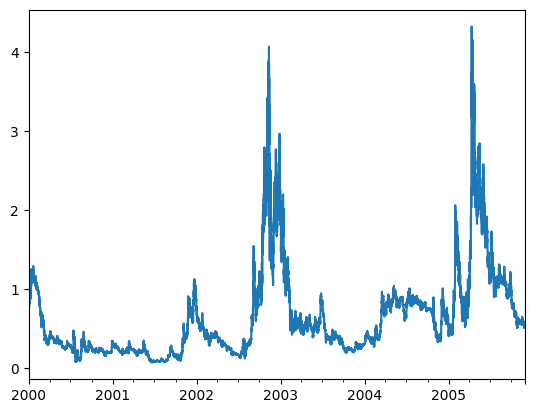

In [4]:
ohlcv_comb = concat_assets(ohlcvs, list(ohlcvs.keys()))
ohlcv_comb.close.plot()

# SMA Strategy

In [5]:

from finlab_crypto.indicators import trends
from finlab_crypto.strategy import Strategy
from finlab_crypto.indicators import trends

@Strategy(name='sma', n1=20, n2=40)
def trend_strategy(ohlcv):
  name = trend_strategy.name
  n1 = trend_strategy.n1
  n2 = trend_strategy.n2

  filtered1 = trends[name](ohlcv.close, n1)
  filtered2 = trends[name](ohlcv.close, n2)

  entries = (filtered1 > filtered2) & (filtered1.shift() < filtered2.shift())
  exit = (filtered1 < filtered2) & (filtered1.shift() > filtered2.shift())

  figures = {
      'overlaps': {
          'trend1': filtered1,
          'trend2': filtered2,
      }
  }
  return entries, exit, figures

trends.keys()

dict_keys(['sma', 'wma', 'lowpass', 'hullma', 'zlma', 'alma', 'detrend', 'linear_reg'])

  0%|          | 0/1458 [00:00<?, ?it/s]

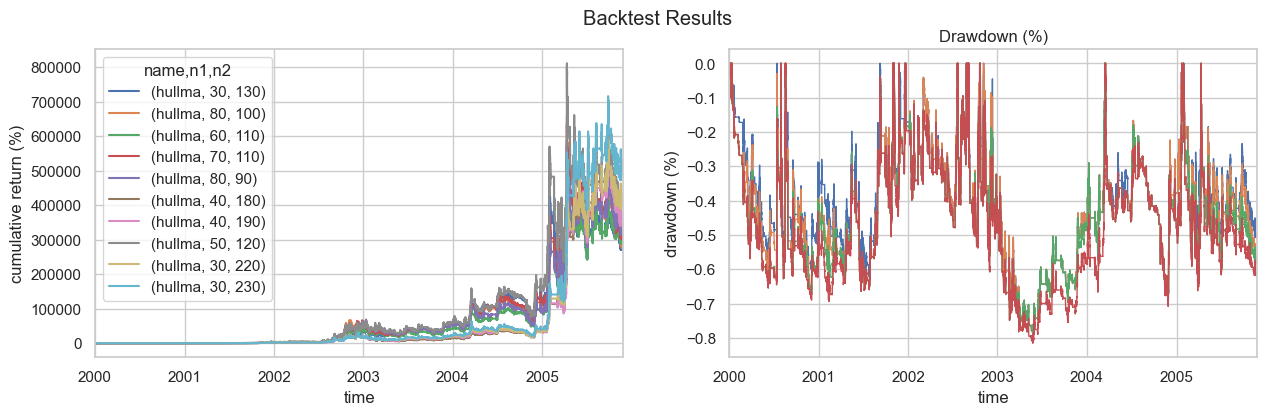

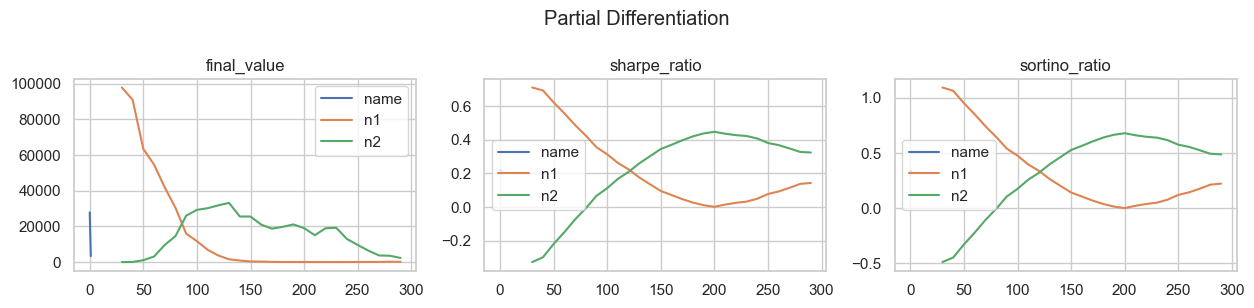

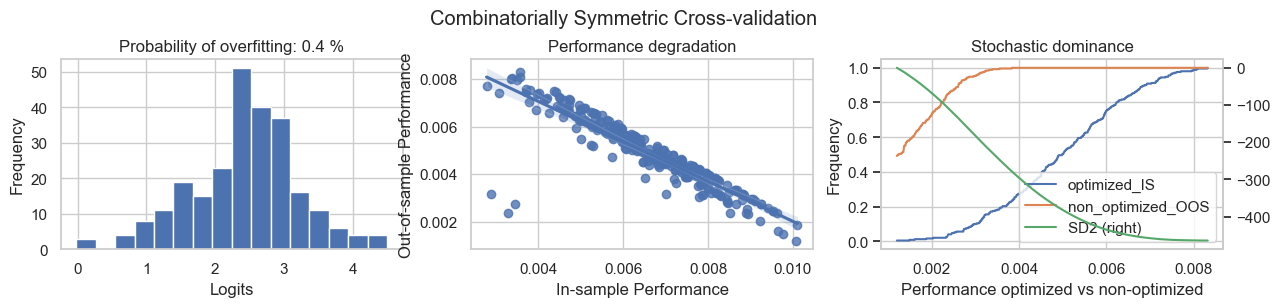

Output()

In [6]:
import numpy as np

portfolio = trend_strategy.backtest(ohlcv_comb, variables={
    'name': ['sma', 'hullma'],
    'n1': np.arange(30, 300, 10),
    'n2': np.arange(30, 300, 10),
}, freq='4h', plot=True)

In [9]:
# inf is infinity
portfolio.sharpe_ratio().replace([np.inf, -np.inf], np.nan).dropna().nlargest(20)

name    n1  n2 
hullma  30  230    0.895543
        50  120    0.885519
        30  220    0.882205
        40  190    0.874599
            180    0.874133
        80  90     0.869009
        70  110    0.864070
        60  110    0.861695
        30  130    0.859951
        70  90     0.858709
        80  100    0.858064
        30  200    0.856148
        70  100    0.855224
        60  120    0.855005
        30  240    0.854665
        60  80     0.851998
        40  130    0.850649
        30  210    0.850117
        50  90     0.847920
        30  110    0.847803
Name: sharpe_ratio, dtype: float64

# Final Strategy

XRPBTC
ADABTC
LINKUSDT
ETHBTC
VETBTC


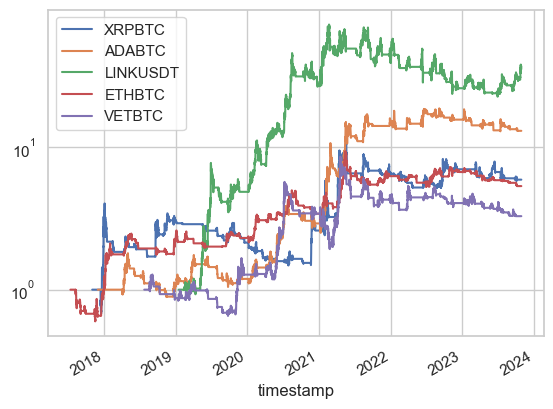

<Axes: xlabel='timestamp'>

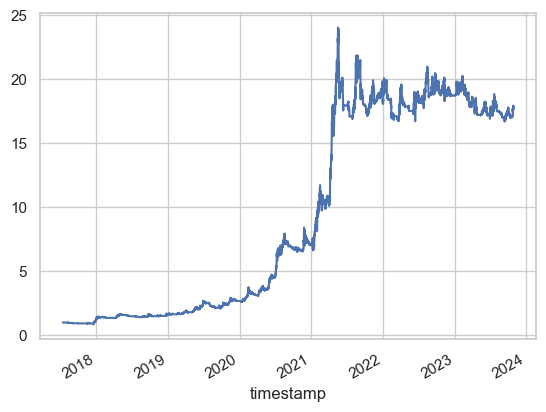

In [10]:
portfolios = {}
for s in ohlcvs.keys():
  print(s)

  portfolios[s] = trend_strategy.backtest(ohlcvs[s].astype(float), dict(
    name='sma',
    n1=30,
    n2=130,
  ), freq='4h', plot=False)


equity = {}
for name, p in portfolios.items():
  equity[name] = p.cumulative_returns()

equity = pd.DataFrame(equity)
(equity+1).plot(logy=True)

import matplotlib.pyplot as plt
plt.show()

(((equity+1).pct_change())+1).fillna(1).mean(axis=1).cumprod().plot()

# Breakout Strategy

  0%|          | 0/1444 [00:00<?, ?it/s]

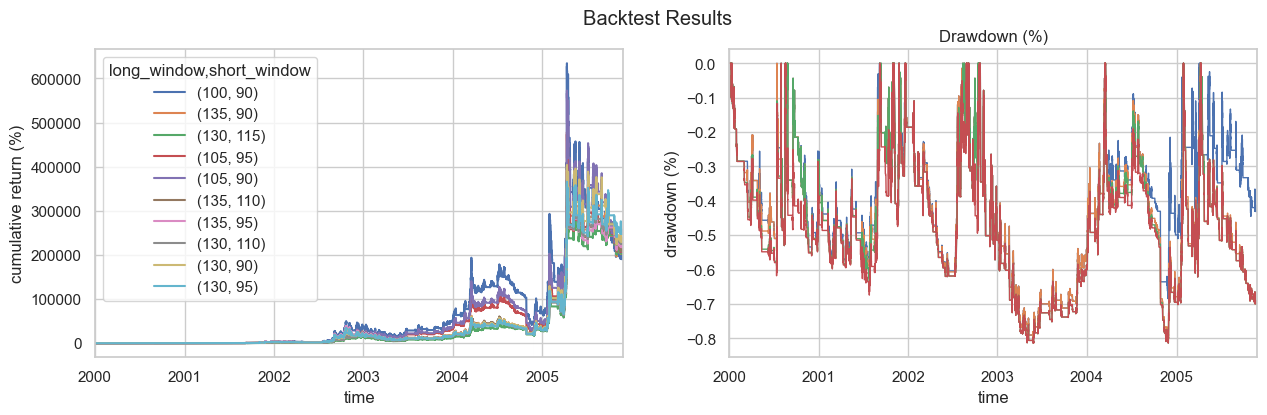

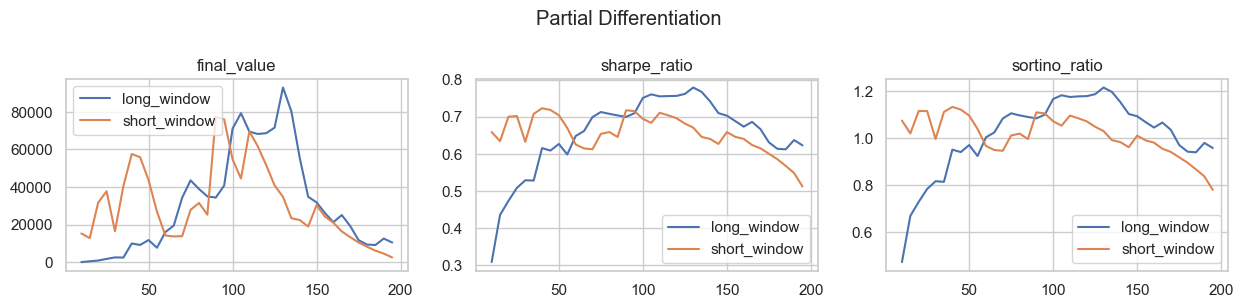

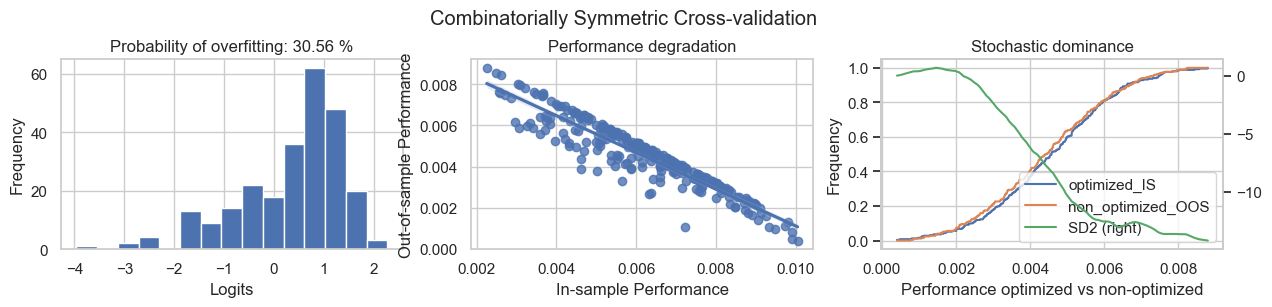

Output()

In [11]:
from finlab_crypto.strategy import Strategy


@Strategy(long_window=30, short_window=30)
def breakout_strategy(ohlcv):
    lw = breakout_strategy.long_window
    sw = breakout_strategy.short_window

    ub = ohlcv.close.rolling(lw).max()
    lb = ohlcv.close.rolling(sw).min()

    # Break through new high to buy
    entries = ohlcv.close == ub
    # Break through new low to sell
    exits = ohlcv.close == lb

    figures = {
        'overlaps': {
            'ub': ub,
            'lb': lb
        }
    }

    return entries, exits, figures

portfolio = breakout_strategy.backtest(ohlcv_comb, variables={
    'long_window': np.arange(10, 200, 5),
    'short_window': np.arange(10, 200, 5),
}, freq='4h', plot=True)

# Fianl Breakout strategy

XRPBTC
ADABTC
LINKUSDT
ETHBTC
VETBTC


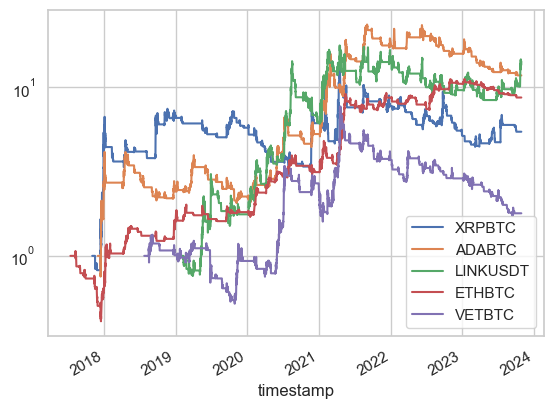

<Axes: xlabel='timestamp'>

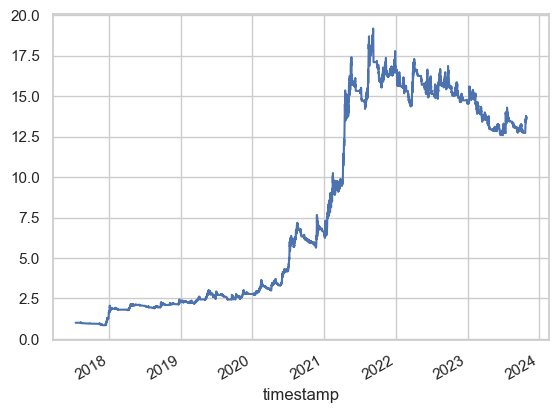

In [12]:
portfolios = {}
for s in ohlcvs.keys():
  print(s)

  portfolios[s] = breakout_strategy.backtest(ohlcvs[s].astype(float), dict(
    long_window=70,
    short_window=40,
  ), freq='4h', plot=False)



equity = {}
for name, p in portfolios.items():
  equity[name] = p.cumulative_returns()

equity = pd.DataFrame(equity)
(equity+1).plot(logy=True)

import matplotlib.pyplot as plt
plt.show()

(((equity+1).pct_change())+1).fillna(1).mean(axis=1).cumprod().plot()

# RSI Strategy

  0%|          | 0/38 [00:00<?, ?it/s]

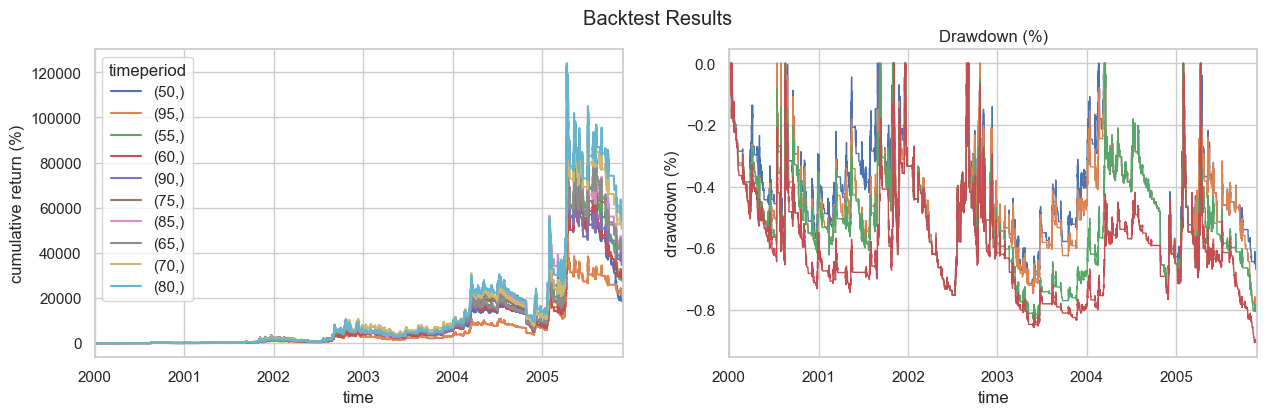

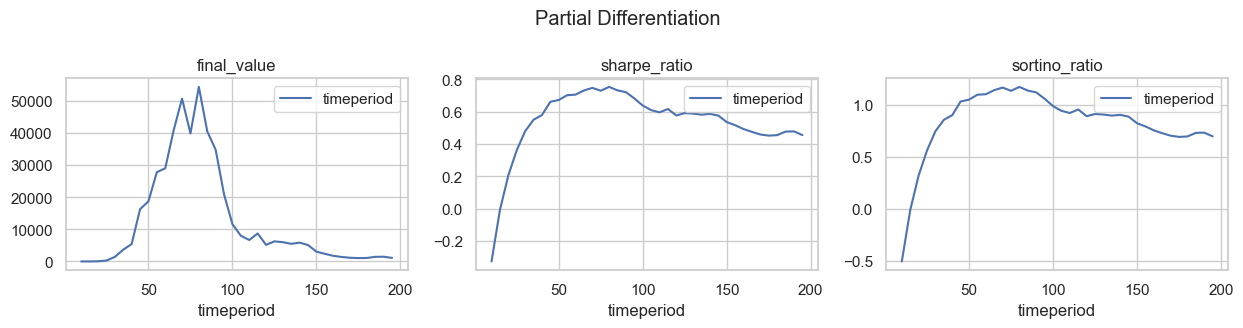

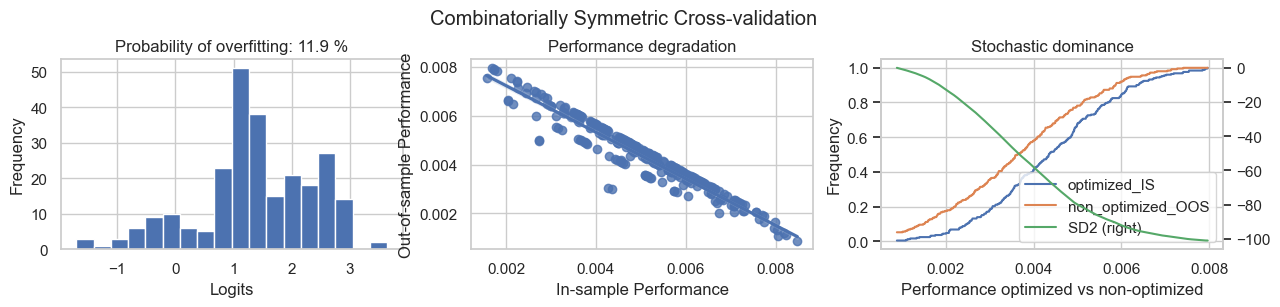

Output()

In [13]:
import talib
import numpy as np
import pandas as pd
from finlab_crypto.strategy import Strategy

@Strategy(timeperiod=14)
def rsi_strategy(ohlcv, combination=False):

  rsi = talib.RSI(ohlcv.close, timeperiod=rsi_strategy.timeperiod)

  entries = rsi > 52
  exits = (rsi < 50)

  figure = {
    'figures': {
        str(rsi_strategy.timeperiod) + '_rsi': rsi
    }
  }

  return entries, exits, figure

portfolio = rsi_strategy.backtest(ohlcv_comb, variables={
    'timeperiod': np.arange(10, 200, 5),
}, freq='4h', plot=True)



# Final RSI Strategy

XRPBTC
ADABTC
LINKUSDT
ETHBTC
VETBTC


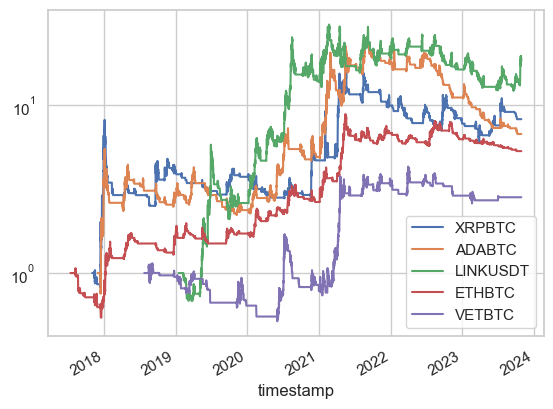

<Axes: xlabel='timestamp'>

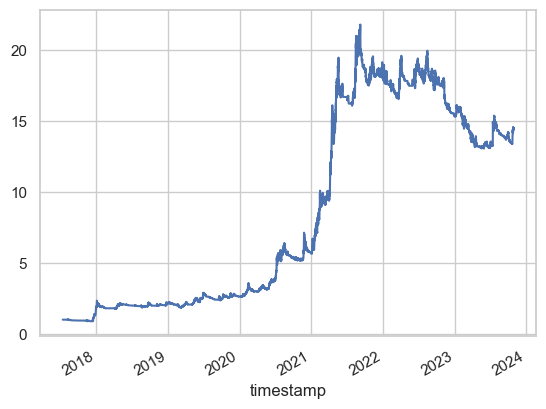

In [14]:
portfolios = {}
for s in ohlcvs.keys():
  print(s)

  portfolios[s] = rsi_strategy.backtest(ohlcvs[s].astype(float), dict(
    timeperiod=60,
  ), freq='4h', plot=False)


equity = {}
for name, p in portfolios.items():
  equity[name] = p.cumulative_returns()

equity = pd.DataFrame(equity)
(equity+1).plot(logy=True)

import matplotlib.pyplot as plt
plt.show()

(((equity+1).pct_change())+1).fillna(1).mean(axis=1).cumprod().plot()